In [1]:
import matplotlib.pyplot as plt
import numpy as np
#!pip3 install tqdm
#!pip3 install --no-cache-dir -I pillow
from tqdm import tqdm

%matplotlib inline

In [2]:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip3 install torchvision

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (30,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


''

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12603626482602826886]

#  Read db and apply data augmentation

In [6]:
#!git clone https://github.com/fgvenegas/Deep-Learning-Pokemon-Image-Generator.git

In [8]:
dataset = dset.ImageFolder(root="root",
       transform=transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.ColorJitter(brightness=0.1, contrast=1.1),
       transforms.RandomVerticalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor(),
]))

In [9]:
#image = tf.image.random_flip_left_right(image)
#image = tf.image.random_brightness(image, max_delta = 0.1)
#image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=int(2))

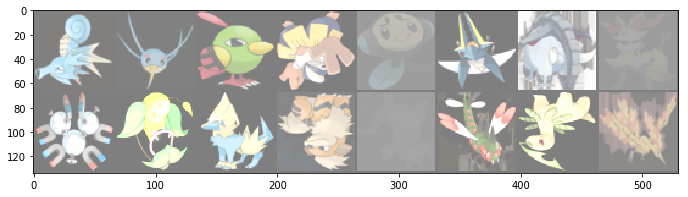

In [11]:
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
for i, data in enumerate(dataloader, 0):
    test, _ = data
    print(test.shape, len(dataloader))
    break


torch.Size([16, 3, 64, 64]) 51


# Gan Model

In [13]:
nc = 3   # n_channels = 3, color image.
ndf = 128 # n_filters disc
ngf = 128 # n_filters gen
nz = 100 # z dimension
batch_size = 128


### Discriminator

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ngpu = 1
        self.main = nn.Sequential(
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
            #                 padding=0, dilation=1, groups=1, bias=True)
            # Bias False It is because BN eliminates the bias (why?), and BN 
            # (with affine=True) adds a bias so it’s equivalent.
            # Input Size nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), #inplace doesn't accumulate memory
            # First layer not apply BN
            # Size ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Size ndf*2 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Size ndf*4 x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            ## Size ndf*8 x 8 x 8
            ## nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            ## nn.BatchNorm2d(ndf * 16),
            ## nn.LeakyReLU(0.2, inplace=True),
            # Size ndf * 8 x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)
    
    

In [16]:
D = Discriminator()

In [17]:
print(D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [18]:
''' Testing discriminator
for i, data in enumerate(dataloader, 0):
    test, _ = data
print(test.shape)
D.forward(Variable(test))
'''

' Testing discriminator\nfor i, data in enumerate(dataloader, 0):\n    test, _ = data\nprint(test.shape)\nD.forward(Variable(test))\n'

### Generator

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngpu=1
        self.main = nn.Sequential(
            # Deconvolution layer is a very unfortunate name and should rather
            # be called a transposed convolutional layer.
            # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
            ##nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            ##nn.BatchNorm2d(ngf * 16),
            ##nn.ReLU(True),
            ## Size ngf * 8 x 4 x 4

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Size ngf * 8 x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size ngf * 4 x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size ngf * 2 x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size ngf x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Size nc x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [20]:
G = Generator()

In [21]:
print(G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Setup

In [22]:
criterion = nn.BCELoss() # I'll always compare the answer of the discriminator
                         # with the Discrimintor using real and fake data and 
                         # with the Generator using only the fake data

In [23]:
input = torch.FloatTensor(batch_size, 3, 128, 128)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
#fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1) # For test generation
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [24]:
# CUDA
use_cuda = True

if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise = noise.cuda()

In [25]:
optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [28]:
n_epochs = 1

In [29]:
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # Discriminator update: max log(D(x)) + log(1 - D(G(z)))
        ## Real training 
        D.zero_grad()
        real, _ = data
        bs = real.size(0)
        if use_cuda and torch.cuda.is_available():
            real = real.cuda()
        input.resize_as_(real).copy_(real)
        label.resize_(bs).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)
      
        output = D(inputv)
        loss_r = criterion(output, labelv)
        loss_r.backward()
      
        ## Fake training
        noise.resize_(bs, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = G(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = D(fake.detach())
        # The computation of gradients wrt the weights of G can be fully
        # avoided in the backward pass if the graph is detached where it is.
        loss_f = criterion(output, labelv)
        loss_f.backward()
      
        loss_d = loss_r + loss_f
        optimizerD.step()
      
        # Generator update max log(D(G(z)))
        G.zero_grad()
        labelv = Variable(label.fill_(real_label))
        output = D(fake)
        loss_g = criterion(output, labelv)
        loss_g.backward()
        optimizerG.step()
      
        print("batch size", bs)
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' 
              % (epoch + 1, n_epochs, i + 1, len(dataloader), loss_d, loss_g))

batch size 16
[1/1][1/51] Loss_D: 1.4300 Loss_G: 4.8192
batch size 16
[1/1][2/51] Loss_D: 1.5463 Loss_G: 5.4169
batch size 16
[1/1][3/51] Loss_D: 1.1789 Loss_G: 4.8666
batch size 16
[1/1][4/51] Loss_D: 2.0308 Loss_G: 6.8923
batch size 16
[1/1][5/51] Loss_D: 1.2818 Loss_G: 4.0755
batch size 16
[1/1][6/51] Loss_D: 2.9354 Loss_G: 6.4162
batch size 16
[1/1][7/51] Loss_D: 0.7902 Loss_G: 5.1497
batch size 16
[1/1][8/51] Loss_D: 2.3216 Loss_G: 7.1436
batch size 16
[1/1][9/51] Loss_D: 0.7991 Loss_G: 6.1182
batch size 16
[1/1][10/51] Loss_D: 0.5488 Loss_G: 5.5270
batch size 16
[1/1][11/51] Loss_D: 1.4018 Loss_G: 7.6065
batch size 16
[1/1][12/51] Loss_D: 1.1537 Loss_G: 5.8502
batch size 16
[1/1][13/51] Loss_D: 0.9830 Loss_G: 6.4606
batch size 16
[1/1][14/51] Loss_D: 0.5031 Loss_G: 5.1159
batch size 16
[1/1][15/51] Loss_D: 2.5526 Loss_G: 6.5582
batch size 16
[1/1][16/51] Loss_D: 1.2988 Loss_G: 6.2091
batch size 16
[1/1][17/51] Loss_D: 0.8469 Loss_G: 3.0572
batch size 16
[1/1][18/51] Loss_D: 2.889

# Test

In [30]:
noise.resize_(16, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = G(noisev)

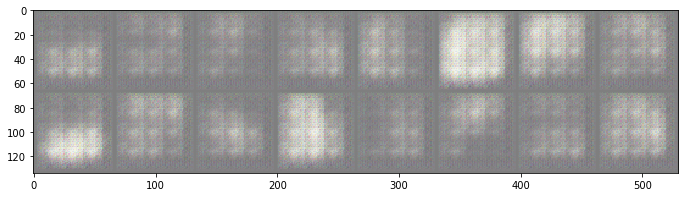

In [31]:
imshow(torchvision.utils.make_grid(fake.data.cpu()))



*   Exportar archivos
*   Tamaño imagenes mostradas
*   Cantidad de imagenes en la bd vs cantidad de epocas entrenado el modelo (Siraj usa apenas 200) - Telegram
*   Desactivar GPU y Guardar jupyer en local



# Save and Load

In [53]:
#torch.save(G.state_dict(), 'G.pth')
#torch.save(D.state_dict(), 'D.pth')

In [57]:
gen = Generator()
gen.load_state_dict(torch.load('G.pth'))

In [ ]:
noise.resize_(16, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = G(noisev)

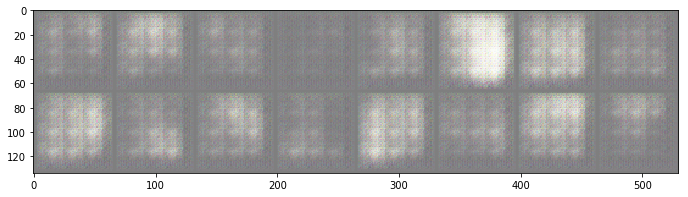

In [50]:
imshow(torchvision.utils.make_grid(fake.data.cpu()))